In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [42]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
T = pd.read_csv('/home/sa42/data/glac/T_models/T.csv')
T.rename(columns = {
    'LAT':'T_LAT_CENT',
    'LON':'T_LON_CENT',
    'AREA':'T_AREA',
    'MEAN_SLOPE':'T_MEAN_SLOPE',
#     'MEAN_THICKNESS':'T_MEAN_THICKNESS',
#     'MAXIMUM_THICKNESS':'T_MAXIMUM_THICKNESS' 
},inplace=True)
TT = pd.read_csv('/home/sa42/data/glac/T_models/TT.csv')
TT.rename(columns = {
    'AREA':'TT_AREA',
    'MEAN_SLOPE':'TT_MEAN_SLOPE',
    'MEAN_THICKNESS':'TT_MEAN_THICKNESS',
#     'MAXIMUM_THICKNESS':'TT_MAXIMUM_THICKNESS', 
    'LOWER_BOUND':'TT_LOWER_BOUND',
    'UPPER_BOUND':'TT_UPPER_BOUND'
},inplace=True)
TTT = pd.read_csv('/home/sa42/data/glac/T_models/TTT.csv')
TTT.rename(columns = {
    'ELEVATION':'TTT_POINT_ELEVATION',
    'THICKNESS':'TTT_POINT_THICKNESS',
    'POINT_LAT':'TTT_POINT_LAT',
    'POINT_LON':'TTT_POINT_LON'
},inplace=True)
# df1 = pd.merge(T,TT, how = 'inner', on='GlaThiDa_ID')
glathida = pd.merge(T,TTT, how = 'inner', on='GlaThiDa_ID')
glathida = glathida[[
#     'GlaThiDa_ID',
#     'GLACIER_DB',
#     'GLACIER_ID',
    'T_LAT_CENT',
    'T_LON_CENT',
    'T_AREA',
    'T_MEAN_SLOPE',
    'T_MEAN_THICKNESS',
    'T_MAXIMUM_THICKNESS',
    'TT_LOWER_BOUND',
    'TT_UPPER_BOUND',
    'TT_AREA',
    'TT_MEAN_SLOPE',
    'TT_MEAN_THICKNESS',
    'TT_MAXIMUM_THICKNESS',
    'TTT_POINT_LAT',
    'TTT_POINT_LON',
    'TTT_POINT_ELEVATION',
    'TTT_POINT_THICKNESS',   
]]
glathida = glathida.dropna()

KeyError: "['T_MEAN_THICKNESS', 'T_MAXIMUM_THICKNESS', 'TT_LOWER_BOUND', 'TT_UPPER_BOUND', 'TT_AREA', 'TT_MEAN_SLOPE', 'TT_MEAN_THICKNESS', 'TT_MAXIMUM_THICKNESS'] not in index"

In [ ]:
df1

### separate out features - what will be trained to predict desired attribute

In [3]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('TTT_POINT_THICKNESS')
test_labels = test_features.pop('TTT_POINT_THICKNESS')

train_features.describe().transpose()[['mean', 'std']]

,mean,std
T_LAT_CENT,45.248784,7.555996
T_LON_CENT,29.965947,36.370518
T_AREA,1.022082,1.387955
T_MEAN_SLOPE,21.421017,5.425289
T_MEAN_THICKNESS,22.792425,16.785250
T_MAXIMUM_THICKNESS,74.305944,45.827023
TT_LOWER_BOUND,2956.907234,678.711591
TT_UPPER_BOUND,2999.129260,693.300833
TT_AREA,0.423253,0.636670
TT_MEAN_SLOPE,23.084023,9.011630


# Step 2: Setup the Model

### Establish normalization layers

In [4]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

  0%|          | 0/15 [00:00<?, ?it/s]2022-03-20 13:11:15.984483: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-20 13:11:15.984539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-20 13:11:15.984969: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


In [5]:
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [6]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 15/15 [38:14<00:00, 152.93s/it]

CPU times: user 49min 10s, sys: 2min 57s, total: 52min 7s
Wall time: 38min 14s


In [7]:
# fig,ax=plt.subplots(2,6,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
# #     mpl_style("dark")
#     ax = plt.subplot(4,4,i+1)
#     plt.subplot(4,4,i+1)
#     gl.plot_loss(linear_history[variable_name])
#     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [8]:
linear_model = gl.build_linear_model(normalizer['ALL'])

linear_history['MULTI'] = linear_model.fit(
train_features, train_labels,        
   epochs=100,
   verbose=0,
   validation_split = 0.2)

linear_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

In [9]:
# gl.plot_loss(history_full)
# # plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [10]:
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [11]:
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 15/15 [1:19:15<00:00, 317.05s/it]


In [12]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(4,4,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     plot_single_model_variable(x,y,variable_name)

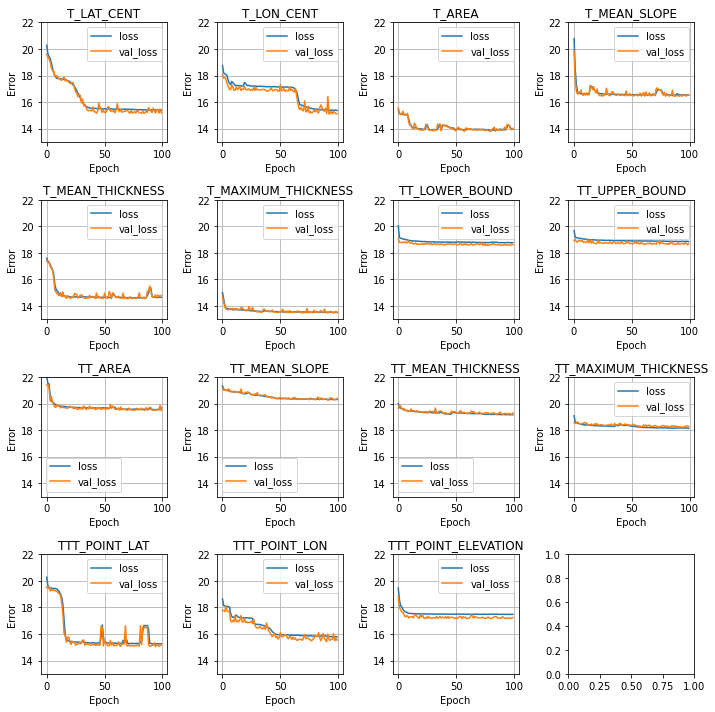

In [36]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
fig.patch.set_facecolor('w')
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(4,4,i+1)
    gl.plot_loss(dnn_history[variable_name])
    ax.set_ylim([13,22])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")
plt.tight_layout()

# Full model

In [14]:
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])

In [15]:
%%time
dnn_history['MULTI'] = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

dnn_results['MULTI'] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

CPU times: user 59min 35s, sys: 12min 35s, total: 1h 12min 11s
Wall time: 5min 35s


<function glacierml.plot_loss(history)>

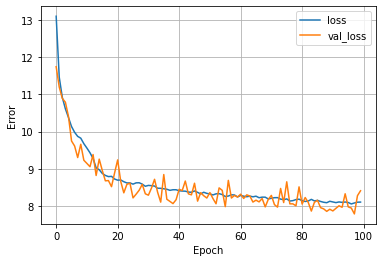

In [16]:
gl.plot_loss(dnn_history['MULTI'])
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

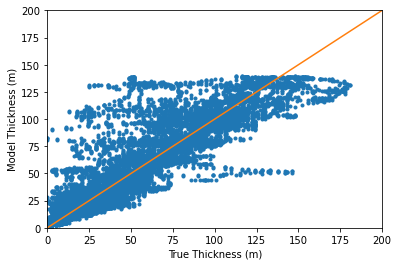

In [17]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

# Collect Results

In [20]:
dfs = pd.DataFrame()
for variable_name in list(dnn_history):    
    df1 = pd.DataFrame(dnn_history[variable_name].history)
    df1 = df1.loc[[df1.last_valid_index()]]
    df1['Architecture'] = 'DNN'
    df1.insert(0, 'Variable', [variable_name])

    df2 = pd.DataFrame(linear_history[variable_name].history)
    df2 = df2.loc[[df2.last_valid_index()]]
    df2['Architecture'] = 'Linear'
    df2.insert(0, 'Variable', [variable_name])
    
    df = pd.concat([df1,df2])
    dfs = dfs.append(df)
    
df = dfs[[
    'Architecture',
    'Variable',
    'loss',
    'val_loss'
]]
df.rename(columns = {
    'loss':'Training Loss',
    'val_loss':'Test loss'
},inplace=True)
df = df.sort_values(by=['Architecture','Variable'], ascending=[False,False])
print(df.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Architecture &             Variable &  Training Loss &  Test loss \\
\midrule
      Linear &     T\_MEAN\_THICKNESS &      17.402643 &  17.552011 \\
      Linear &         T\_MEAN\_SLOPE &      21.767887 &  21.823973 \\
      Linear &  T\_MAXIMUM\_THICKNESS &      15.347433 &  15.457845 \\
      Linear &           T\_LON\_CENT &      19.385271 &  19.129791 \\
      Linear &           T\_LAT\_CENT &      23.644772 &  23.652906 \\
      Linear &               T\_AREA &      15.417509 &  15.471154 \\
      Linear &       TT\_UPPER\_BOUND &      20.809742 &  20.641459 \\
      Linear &    TT\_MEAN\_THICKNESS &      20.649927 &  20.732315 \\
      Linear &        TT\_MEAN\_SLOPE &      22.467310 &  22.424276 \\
      Linear & TT\_MAXIMUM\_THICKNESS &      19.628298 &  19.747486 \\
      Linear &       TT\_LOWER\_BOUND &      20.793865 &  20.632185 \\
      Linear &              TT\_AREA &      23.620951 &  23.646055 \\
      Linear &        TTT\_POINT\_LON &  